In [6]:
# !pip install pystan
# !pip install fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from chart_studio import plotly 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [7]:
cdc_data = pd.read_csv('CDC_dataset.csv')

In [8]:
cdc_data.describe()

,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death
count,4.116000e+04,2.199100e+04,21919.000000,41160.000000,37159.000000,41160.000000,21771.000000,21771.000000,41160.000000,37098.000000
mean,3.334831e+05,3.577318e+05,45340.923582,1190.070505,182.406039,6178.508285,6902.206513,703.874007,18.815403,1.819209
std,5.997560e+05,5.650308e+05,69517.962414,2544.563086,520.709600,10332.127070,9309.179176,1094.737914,45.622450,27.823309
min,0.000000e+00,0.000000e+00,0.000000,-10199.000000,-10733.000000,0.000000,0.000000,0.000000,-352.000000,-2594.000000
25%,5.450000e+03,3.349200e+04,12.000000,28.000000,0.000000,116.000000,747.000000,0.000000,0.000000,0.000000
50%,1.028975e+05,1.538920e+05,8195.000000,351.000000,4.000000,1865.000000,3460.000000,208.000000,4.000000,0.000000
75%,4.329145e+05,4.996240e+05,63843.500000,1267.000000,145.000000,7819.250000,9513.500000,901.000000,18.000000,1.000000
max,5.113467e+06,4.851429e+06,381613.000000,61016.000000,16591.000000,74221.000000,71408.000000,5208.000000,1178.000000,2919.000000


In [9]:
cdc_data.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,04/01/2021,CA,3570660,3570660.0,0.0,2234,0.0,58090,58090.0,0.0,154,0.0,04/03/2021 12:00:00 AM,Agree,Agree
1,05/31/2021,CA,3685032,3685032.0,0.0,644,0.0,62011,62011.0,0.0,5,0.0,06/02/2021 12:00:00 AM,Agree,Agree
2,02/06/2020,NE,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
3,07/30/2020,ME,3910,3497.0,413.0,22,2.0,123,122.0,1.0,2,0.0,07/31/2020 02:35:06 PM,Agree,Agree
4,02/02/2021,MS,280182,176228.0,103954.0,1059,559.0,6730,4739.0,1991.0,13,7.0,02/04/2021 12:00:00 AM,Agree,Agree


In [10]:
#Dropping columns which are not needed and renaming
cdc_data.drop(columns = ['tot_cases','tot_death','prob_cases','pnew_case','prob_death','pnew_death','consent_cases','consent_deaths','created_at'], inplace= True) 
cdc_data.rename(columns = {'submission_date':'Date','state':'State','conf_cases':'Total_cases_cum','new_case':'daily_cases','conf_death':'Total_deaths_cum','new_death':'daily_deaths'},inplace = True)
cdc_data['Date'] = pd.to_datetime(cdc_data['Date'])

In [11]:
cdc_data.set_index('Date')

,State,Total_cases_cum,daily_cases,Total_deaths_cum,daily_deaths
Date,,,,,
2021-04-01,CA,3570660.0,2234,58090.0,154
2021-05-31,CA,3685032.0,644,62011.0,5
2020-02-06,NE,NaN,0,NaN,0
2020-07-30,ME,3497.0,22,122.0,2
2021-02-02,MS,176228.0,1059,4739.0,13
...,...,...,...,...,...
2020-07-19,NJ,NaN,-10,13732.0,34
2021-08-13,FSM,7.0,0,0.0,0
2020-12-15,DC,NaN,301,NaN,4


In [18]:
cdc_data = cdc_data.dropna()

,Date,State,Total_cases_cum,daily_cases,Total_deaths_cum,daily_deaths
0,2021-04-01,CA,3570660.0,2234,58090.0,154
1,2021-05-31,CA,3685032.0,644,62011.0,5
3,2020-07-30,ME,3497.0,22,122.0,2
4,2021-02-02,MS,176228.0,1059,4739.0,13
7,2021-03-10,AL,395544.0,883,8565.0,17
...,...,...,...,...,...,...
41144,2020-12-29,FSM,0.0,0,0.0,0
41151,2020-08-09,FSM,0.0,0,0.0,0
41152,2020-07-23,OR,14900.0,319,269.0,2
41156,2021-08-13,FSM,7.0,0,0.0,0


#### For Analysis Grouping the data by the date

In [12]:
US_data = cdc_data.groupby('Date',as_index = True).sum()

Text(0.5, 1.0, 'Daily Covid-19 Cases')

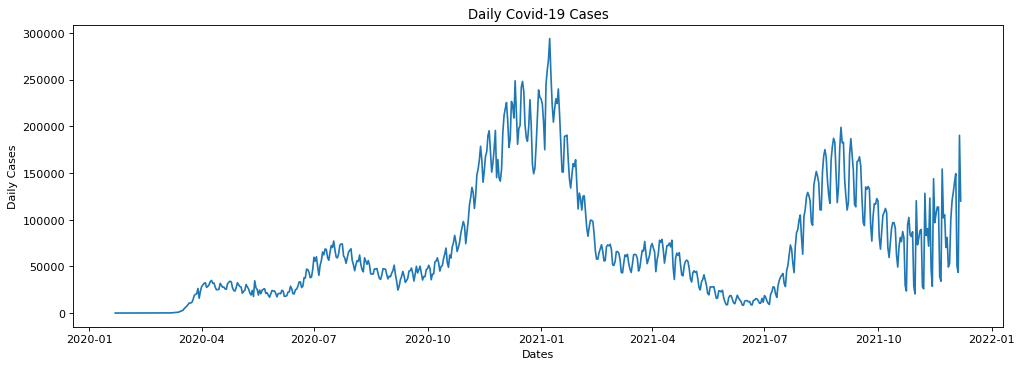

In [13]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['daily_cases'])
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Cases')

In [14]:
#7 day moving average
US_data['daily_deaths_sma7'] = US_data['daily_deaths'].rolling(window=7).mean()
US_data['daily_cases_sma7'] = US_data['daily_cases'].rolling(window=7).mean()

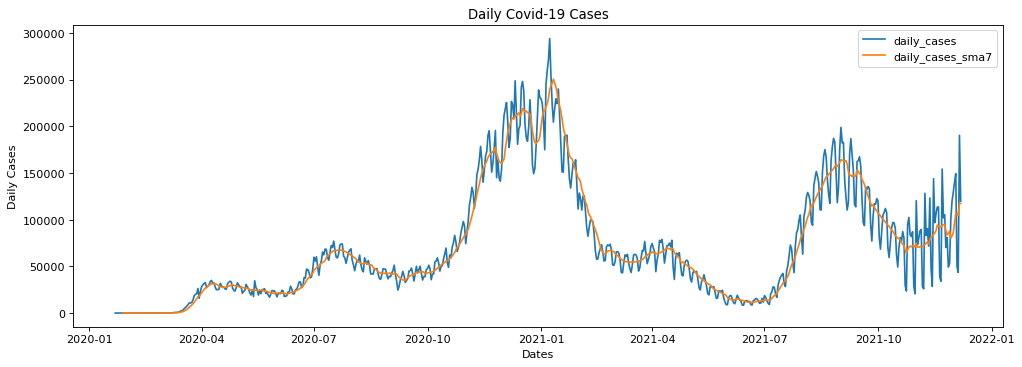

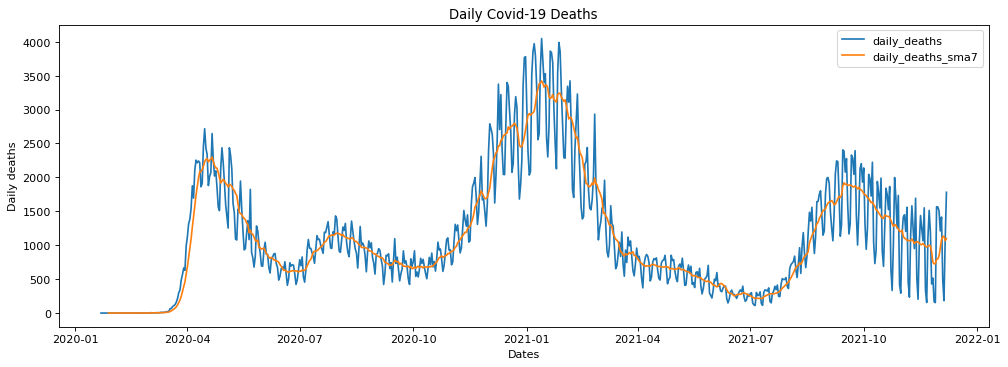

In [15]:
#Smooth curve after calculating moving averages

figure(figsize=(15, 5), dpi=80)
plt.plot(US_data[['daily_cases','daily_cases_sma7']])
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Cases')
plt.legend(['daily_cases','daily_cases_sma7'])


figure(figsize=(15, 5), dpi=80)
plt.plot(US_data[['daily_deaths','daily_deaths_sma7']])
plt.ylabel('Daily deaths')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Deaths')
plt.legend(['daily_deaths','daily_deaths_sma7'])

#### Forecasting using Time Series Analysis 

In [17]:
# split training set and test set 
train=cdc_data.iloc[:int(cdc_data.shape[0]*0.80)]
test=cdc_data.iloc[int(cdc_data.shape[0]*0.20):]
pred=test.copy()

#### 1.) SARIMA ( The data is seasonal and hence using  Seasonal ARIMA)

In [19]:
model_sarima= auto_arima(train["daily_cases"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                         suppress_warnings=True,stepwise=False,seasonal=True)
model_sarima.fit(train["daily_cases"])

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=632536.938, Time=1.19 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=632532.764, Time=3.33 sec


MemoryError: Unable to allocate 4.02 MiB for an array with shape (16, 32928) and data type float64

In [ ]:
prediction_sarima=model_sarima.predict(len(test))
pred["SARIMA Model Prediction"]=prediction_sarima


In [ ]:
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(test["tot_cases"],prediction_sarima)))

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["tot_cases"],mode='lines+markers',name="Train Data for Cumulative Confirmed Cases"))
fig.add_trace(go.Scatter(x=test.index, y=test["tot_cases"],mode='lines+markers',name="Test Data for Cumulative Confirmed Cases",))
fig.add_trace(go.Scatter(x=test.index, y=pred["SARIMA Model Prediction"],mode='lines+markers',name="Prediction for Cumulative Confirmed Cases",))
fig.update_layout(title="SARIMA Prediction for Cumulative Confirmed Cases",xaxis_title="Date",yaxis_title="Cumulative Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()